In [1]:
import sys

full_path_to_modul_dir = 'D:/mcbj_stmbj'  # here enter the full path to the directory that contains the modul on your computer
sys.path.append(full_path_to_modul_dir)

import re
import os
import warnings
warnings.filterwarnings("error")

In [2]:
from mcbj import *
import filter_traces
import plots
import seaborn as sns
import matplotlib.patches as patches

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

date_1 = "22_02_03"
date_2 = "22_03_23"
sample_rate = 50_000
home_folder_1 = Path(f"D:/BJ_Data/{date_1}")
home_folder_2 = Path(f"D:/BJ_Data/{date_2}")
# home_folder = Path(f"//DATACENTER/BreakJunction_group/BJ_Data/{date}")

In [ ]:
which_trace = 43008

hold_trace = HoldTrace(which_trace,
                       load_from=home_folder, bias_offset=0,
                       r_serial_ohm=99_900, min_step_len=20_000, min_height=1, iv=0)

trace_pair = TracePair(which_trace, load_from=home_folder)

hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=False)

ax_trace, ax_hold, par_hold, ax_iv, ax_psd = plots.plot_ivs_scheme_one(trace_pair=trace_pair, hold_trace=hold_trace, direction='pull',
                                                                       smoothing=10, which_psds=[0, 1, 2])

In [36]:
def igor_gaussian_fun(x, y0, A, x0, width):
    
    """
    x0: mean
    width/2: variance
    A: amplitude
    y0: vertical offset
    """
    
    return y0 + A * np.exp( -1 * ((x - x0)/width)**2 )

In [3]:
def calc_noise_sim(sim_data_df, dgap=0.0, dphi=0.0, verbose=False):
    """
    Calculates noise from simulation data.
    You can select which parameter you want to be fluctuating and set the other to zero.
    If both values are nonzero, both parameters fluctuate.
    
    Parameters
    ----------
    sim_data_df: `pd.DataFrame` containing data from Laci's simulation software. (best fit parameters)
    dgap: float, gap fluctuation in nm, default: 0.0
    dphi: float, barrier fluctuation in eV, default: 0.0
        
    Returns
    -------
    calculated relative noise (dG/G) with the given fluctuating variables (dgap, dphi).
    """
    
    # 1e-9
    # 1.6e-19
    
    # if dgap is None and dphi is None:
    #     raise ValueError(f'You entered dgap={dgap} and dphi={dphi}. One of them has to be not `None`')
    # elif dgap is None:
    #     print("Calculating relative noise when the barrier fluctuates.")
    #     sim_fluct_relnoise_push = sim_data_df['dR/dPhi'] * dphi * 1.6e-19 / sim_data_df['R [Ohm]']
    # elif dphi is None:
    #     print("Calculating relative noise when the gap fluctuates.")
    #     sim_fluct_relnoise_push = sim_data_df['dR/dz'] * dgap * 1e-9 / sim_data_df['R [Ohm]']
    # else:
    #     print("Calculating relative noise when both the barrier and the gap fluctuates.")
    #     sim_fluct_relnoise_push = np.sqrt((sim_data_df['dR/dz'] * dgap * 1e-9)**2 + (sim_data_df['dR/dPhi'] * dphi * 1.6e-19)**2) / sim_data_df['R [Ohm]']
    #    
    # return sim_fluct_relnoise_push
    if verbose:
        print(f"Calculating relative noise when the barrier fluctuation is dphi={dphi} eV and the gap fluctuation is dgap={dgap} nm.")
    
    # multiply by 1e-9 so the unit is nanometer
    # multiply by 1.6e-19 (unit charge) so the unit is eV
    
    return (np.sqrt((sim_data_df['dR/dz'] * dgap * 1e-9)**2 + (sim_data_df['dR/dPhi'] * dphi * 1.6e-19)**2) / sim_data_df['R [Ohm]']).to_numpy()

In [4]:
def calc_2D_rel_noise_hists(df: pd.DataFrame, x_vars: Tuple[str, ...], y_vars: Tuple[str, ...],                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                            log_scale=True, bin_mode='total'):
   
    x_bins_all = []
    y_bins_all = []
    x_hist1d_all = []
    y_hist1d_all = []
    x_mesh_all = []
    y_mesh_all = []
    hist2d_all = []
    
    for i in range(len(x_vars)):        
        x_bins, x_hist1d = utils.calc_hist_1d_single(data=df[x_vars[i]], xrange=xrange,
                                                     xbins_num=xbins_num, log_scale=log_scale, bin_mode=bin_mode)
        y_bins, y_hist1d = utils.calc_hist_1d_single(data=df[y_vars[i]], xrange=yrange,
                                                     xbins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)

        h, xedges, yedges = np.histogram2d(df[x_vars[i]], df[y_vars[i]],
                                           bins=[x_bins, y_bins])
        x_mesh, y_mesh = np.meshgrid(xedges, yedges)
        
        x_bins_all.append(x_bins)
        y_bins_all.append(y_bins)
        x_hist1d_all.append(x_hist1d)
        y_hist1d_all.append(y_hist1d)
        hist2d_all.append(h.T)
        x_mesh_all.append(x_mesh)
        y_mesh_all.append(y_mesh)
        
    return x_bins_all, x_hist1d_all, y_bins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all
    

def plot_2D_rel_noise_hists(df: pd.DataFrame, x_vars: Tuple[str, ...], y_vars: Tuple[str, ...],                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                            log_scale=True, bin_mode='total', figsize=utils.cm2inch(16, 5), dpi=600,
                            cmap='viridis', **kwargs):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, len(x_vars), figure=fig,
                      left=0.08, right=0.92, top=0.9, bottom=0.13,
                      hspace=0.0, wspace=0.0)
    ax = []
    
    xbins_all, x_hist1d_all, ybins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
        calc_2D_rel_noise_hists(df=df,
                                x_vars=x_vars, y_vars=y_vars,
                                xrange=xrange, yrange=yrange,
                                xbins_num=xbins_num, ybins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)
    
    for i in range(len(x_vars)):
        ax.append(fig.add_subplot(gs[i]))
        im_pull = ax[i].pcolormesh(x_mesh_all[i], y_mesh_all[i], hist2d_all[i], cmap=cmap, **kwargs)
        
        ax[i].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                          labelleft=False, labelright=False, labeltop=False, labelbottom=True)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(x_vars[i])
        ax[i].set_ylabel(y_vars[i])
        
    ax[0].tick_params(which='both',
                      labelleft=True, labelright=False, labeltop=False, labelbottom=True)
    ax[-1].tick_params(which='both',
                      labelleft=False, labelright=True, labeltop=False, labelbottom=True)
    
    return fig, ax
    
def plot_2D_rel_noise_hist_and_scatter(df: pd.DataFrame,
                                       x_2d_vars: Tuple[str, ...], y_2d_vars: Tuple[str, ...],
                                       x_scat_vars: Tuple[str, ...], y_scat_vars: Tuple[str, ...],
                                       xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                                       log_scale=True, bin_mode='total', cmap='viridis',
                                       figsize=utils.cm2inch(16, 10), dpi=600, **kwargs):
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, len(x_2d_vars), figure=fig,
                      left=0.08, right=0.92, top=0.9, bottom=0.13,
                      hspace=0.0, wspace=0.0)
    ax = []
    
    xbins_all, x_hist1d_all, ybins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
        calc_2D_rel_noise_hists(df=df,
                                x_vars=x_2d_vars, y_vars=y_2d_vars,
                                xrange=xrange, yrange=yrange,
                                xbins_num=xbins_num, ybins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)
    
    for i in range(len(x_2d_vars)):
        ax.append(fig.add_subplot(gs[i]))
        im_pull = ax[i].pcolormesh(x_mesh_all[i], y_mesh_all[i], hist2d_all[i], cmap=cmap)
        
        for j in range(len(x_scat_vars)):
            ax[i].scatter(df[x_scat_vars[j]], df[y_scat_vars[j]], **kwargs)
        
        ax[i].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                          labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(x_2d_vars[i])
        ax[i].set_ylabel(x_2d_vars[i])
        
    return fig, ax

In [91]:
sim_data_pull = pd.read_excel(io=home_folder_1.joinpath('results/IVs/selected/Tunnel_22_02_03_pull_fits_all.xlsx'))
sim_data_push = pd.read_excel(io=home_folder_1.joinpath('results/IVs/selected/Tunnel_22_02_03_push_fits_all.xlsx'))

In [92]:
noise_pull = pd.read_csv(home_folder_1.joinpath('results/IVs/selected/noise_data_pull.csv'))
noise_push = pd.read_csv(home_folder_1.joinpath('results/IVs/selected/noise_data_push.csv'))

In [93]:
sim_data_pull['Part'] = sim_data_pull['Fit Trace'].map(lambda x: int(re.search(r'(\d)\_IV\w*', x).group(1)))
sim_data_pull['G [G0]'] = sim_data_pull['R [Ohm]'].map(utils.convert_ohm_to_g0)

In [94]:
sim_data_push['Part'] = sim_data_push['Fit Trace'].map(lambda x: int(re.search(r'(\d)\_IV\w*', x).group(1)))
sim_data_push['G [G0]'] = sim_data_push['R [Ohm]'].map(utils.convert_ohm_to_g0)

In [95]:
sim_data_pull = sim_data_pull.sort_values(by=['Trace', 'Part'])
sim_data_push = sim_data_push.sort_values(by=['Trace', 'Part'])

In [96]:
sim_data_pull['G_meas1 [G0]'] = np.vstack((noise_pull['avg_cond_1'],
                                           noise_pull['avg_cond_1'], 
                                           noise_pull['avg_cond_1'], 
                                           noise_pull['avg_cond_1'])).T.flatten()

sim_data_pull['G_meas2 [G0]'] = np.vstack((noise_pull['avg_cond_2'],
                                           noise_pull['avg_cond_2'], 
                                           noise_pull['avg_cond_2'], 
                                           noise_pull['avg_cond_2'])).T.flatten()

sim_data_pull['dG/G_meas1'] = np.vstack((noise_pull['conductance_noise_1'],
                                         noise_pull['conductance_noise_1'], 
                                         noise_pull['conductance_noise_1'], 
                                         noise_pull['conductance_noise_1'])).T.flatten()

sim_data_pull['dG/G_meas2'] = np.vstack((noise_pull['conductance_noise_2'],
                                         noise_pull['conductance_noise_2'], 
                                         noise_pull['conductance_noise_2'], 
                                         noise_pull['conductance_noise_2'])).T.flatten()

In [97]:
sim_data_push['G_meas1 [G0]'] = np.vstack((noise_push['avg_cond_1'],
                                           noise_push['avg_cond_1'], 
                                           noise_push['avg_cond_1'], 
                                           noise_push['avg_cond_1'])).T.flatten()

sim_data_push['G_meas2 [G0]'] = np.vstack((noise_push['avg_cond_2'],
                                           noise_push['avg_cond_2'], 
                                           noise_push['avg_cond_2'], 
                                           noise_push['avg_cond_2'])).T.flatten()

sim_data_push['dG/G_meas1'] = np.vstack((noise_push['conductance_noise_1'],
                                         noise_push['conductance_noise_1'], 
                                         noise_push['conductance_noise_1'], 
                                         noise_push['conductance_noise_1'])).T.flatten()

sim_data_push['dG/G_meas2'] = np.vstack((noise_push['conductance_noise_2'],
                                         noise_push['conductance_noise_2'], 
                                         noise_push['conductance_noise_2'], 
                                         noise_push['conductance_noise_2'])).T.flatten()

## Filter those where barrier < 2

In [98]:
sim_data_pull = sim_data_pull[sim_data_pull['Phi - Barrier [eV]'] < 2]

sim_data_push = sim_data_push[sim_data_push['Phi - Barrier [eV]'] < 2]

In [99]:
sim_data_pull[['R [Ohm]', 'G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]']]

,R [Ohm],G_meas1 [G0],G_meas2 [G0],G [G0]
0,13069957.0,0.002974,0.001155,0.000987
639,12976073.0,0.002974,0.001155,0.000994
1278,17213803.0,0.002974,0.001155,0.000749
1917,20498335.0,0.002974,0.001155,0.000629
1,3730296.1,0.005064,0.002731,0.003458
...,...,...,...,...
10054,63364976.0,0.000408,0.000161,0.000204
4430,16774953.0,0.001002,0.000760,0.000769
6305,15951589.0,0.001002,0.000760,0.000809
8180,18777990.0,0.001002,0.000760,0.000687


In [100]:
utils.convert_ohm_to_g0(12976073.0)

0.0009941374405029934

In [101]:
sim_data_push

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0]
0,19515,'1_IV_trace_19515_push_pl',123337740.0,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,0.046079,1,0.000105
4413,19515,'2_IV_trace_19515_push_pl',115852820.0,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,0.046079,2,0.000111
8826,19515,'3_IV_trace_19515_push_pl',118121180.0,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,0.046079,3,0.000109
13239,19515,'4_IV_trace_19515_push_pl',115108080.0,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,0.046079,4,0.000112
1,19529,'1_IV_trace_19529_push_pl',172076560.0,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,0.089175,1,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23068,49083,'3_IV_trace_49083_push_pl',104710350.0,0.43,1.27,1.394623e+18,9.722801e+26,0.000113,0.088571,0.000294,0.168821,3,0.000123
19457,49088,'1_IV_trace_49088_push_pl',195853160.0,0.47,1.33,2.604451e+18,1.969822e+27,0.000067,0.066466,0.000087,0.032976,1,0.000066
21263,49088,'2_IV_trace_49088_push_pl',201705620.0,0.50,1.13,2.508884e+18,2.352905e+27,0.000067,0.066466,0.000087,0.032976,2,0.000064
23069,49088,'3_IV_trace_49088_push_pl',224151430.0,0.52,1.06,2.703747e+18,2.815920e+27,0.000067,0.066466,0.000087,0.032976,3,0.000058


In [102]:
meas_data_pull = sim_data_pull.groupby('Trace')[['G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]', 'dG/G_meas2']].mean()
meas_data_push = sim_data_push.groupby('Trace')[['G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]', 'dG/G_meas2']].mean()

In [103]:
meas_data_pull

,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2
Trace,,,,
19522,0.002974,0.085796,0.001155,0.143681
19811,0.005064,0.107289,0.002731,0.043851
19877,0.006574,0.035293,0.004031,0.025566
19905,0.011038,0.055643,0.007856,0.023391
19998,0.005919,0.052609,0.002665,0.054060
...,...,...,...,...
48454,0.000358,0.075724,0.000124,0.081056
48668,0.000072,0.168055,0.000056,0.071779
48837,0.002246,0.073720,0.001449,0.050695


In [104]:
meas_data_push

,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2
Trace,,,,
19515,0.000104,0.098067,0.000115,0.046079
19529,0.000081,0.070921,0.000086,0.089175
19535,0.000098,0.060375,0.000077,0.131780
19536,0.000123,0.105979,0.000136,0.049800
19568,0.000111,0.069067,0.000122,0.078762
...,...,...,...,...
49057,0.000080,0.283386,0.000102,0.138958
49067,0.000160,0.059936,0.000397,0.046973
49072,0.000086,0.104733,0.000123,0.073369


In [105]:
my_cmap = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1), colormaps['viridis'](np.linspace(0.0, 1.0, 31)))))


my_cmap_blues = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1),
                                          colormaps['viridis'](np.linspace(0.0, 1.0, 31)))))
my_cmap_reds = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1),
                                         colormaps['plasma'](np.linspace(0.0, 1.0, 31)))))

In [27]:
def calc_sq_diff(y1, y2, log_scale=True):
    if log_scale:
        y1 = np.log10(y1)
        y2 = np.log10(y2)
        
    return np.sum((y1-y2)**2)

def plot_sq_diff(dFluct, PhiFluct, sq_diff_all_1, sq_diff_all_2, plot_min=True, xlim=None, ylim=None):
    
    fig, ax = plt.subplots(ncols=2, figsize=utils.cm2inch(14, 5), dpi=300)

    # xbins = PhiFluct
    # ybins = dFluct

    # print(np.diff(PhiFluct)[0])
    # print(np.diff(dFluct)[0])
    
    ind1 = np.unravel_index(np.argmin(sq_diff_all_1, axis=None), sq_diff_all_1.shape)
    ind2 = np.unravel_index(np.argmin(sq_diff_all_2, axis=None), sq_diff_all_2.shape)

    x_mesh, y_mesh = np.meshgrid(dFluct, PhiFluct)

    im1 = ax[0].pcolormesh(x_mesh, y_mesh, sq_diff_all_1.T, cmap='hot', vmin=min(sq_diff_all_1.flatten()), vmax=1.2*min(sq_diff_all_1.flatten()))
    fig.colorbar(im1, ax=ax[0], extend='max')
    im2 = ax[1].pcolormesh(x_mesh, y_mesh, sq_diff_all_2.T, cmap='hot', vmin=min(sq_diff_all_2.flatten()), vmax=1.2*min(sq_diff_all_2.flatten()))
    fig.colorbar(im2, ax=ax[1], extend='max')

    # ax[0].scatter(PhiFluct[ind1[0]], dFluct[ind1[1]], c='white', s=1)
    # ax[1].plot(PhiFluct[ind2[0]], dFluct[ind2[1]], markersize=1, marker='s', fillstyle='none')

    # Create a Rectangle patch
    # rect1 = patches.Rectangle((dFluct[ind1[1]]-0.00005, PhiFluct[ind1[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')
    # rect2 = patches.Rectangle((dFluct[ind2[1]]-0.00005, PhiFluct[ind2[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')

    # Add the patch to the Axes
    # ax[0].add_patch(rect1)
    # ax[1].add_patch(rect2)
    
    if plot_min:
        ax[0].scatter(dFluct[ind1[0]], PhiFluct[ind1[1]], s=1, label=f'({np.round(dFluct[ind1[0]], 5)}, {np.round(PhiFluct[ind1[1]], 5)})')
        ax[1].scatter(dFluct[ind2[0]], PhiFluct[ind2[1]], s=1, label=f'({np.round(dFluct[ind2[0]], 5)}, {np.round(PhiFluct[ind2[1]], 5)})')
    
    if xlim is not None:
        ax[0].set_xlim(xlim[0], xlim[1])
        ax[1].set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax[0].set_ylim(ylim[0], ylim[1])
        ax[1].set_ylim(ylim[0], ylim[1])

    ax[0].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[0].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    ax[1].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[1].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    
    ax[0].legend(fontsize=6)
    ax[1].legend(fontsize=6)
    
    return ax

In [28]:
def plot_sq_diff_1(dFluct, PhiFluct, sq_diff_all_1, sq_diff_all_2, plot_min=True, xlim=None, ylim=None, **kwargs):
    
    fig, ax = plt.subplots(ncols=2, figsize=utils.cm2inch(14, 5), dpi=300)

    # xbins = PhiFluct
    # ybins = dFluct

    # print(np.diff(PhiFluct)[0])
    # print(np.diff(dFluct)[0])
    
    ind1 = np.unravel_index(np.argmin(sq_diff_all_1, axis=None), sq_diff_all_1.shape)
    ind2 = np.unravel_index(np.argmin(sq_diff_all_2, axis=None), sq_diff_all_2.shape)

    x_mesh, y_mesh = np.meshgrid(dFluct, PhiFluct)

    im1 = ax[0].pcolormesh(x_mesh, y_mesh, sq_diff_all_1.T, cmap='hot', **kwargs)
    fig.colorbar(im1, ax=ax[0], extend='max')
    im2 = ax[1].pcolormesh(x_mesh, y_mesh, sq_diff_all_2.T, cmap='hot', **kwargs)
    fig.colorbar(im2, ax=ax[1], extend='max')

    # ax[0].scatter(PhiFluct[ind1[0]], dFluct[ind1[1]], c='white', s=1)
    # ax[1].plot(PhiFluct[ind2[0]], dFluct[ind2[1]], markersize=1, marker='s', fillstyle='none')

    # Create a Rectangle patch
    # rect1 = patches.Rectangle((dFluct[ind1[1]]-0.00005, PhiFluct[ind1[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')
    # rect2 = patches.Rectangle((dFluct[ind2[1]]-0.00005, PhiFluct[ind2[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')

    # Add the patch to the Axes
    # ax[0].add_patch(rect1)
    # ax[1].add_patch(rect2)
    
    if plot_min:
        ax[0].scatter(dFluct[ind1[0]], PhiFluct[ind1[1]], s=1, label=f'({np.round(dFluct[ind1[0]], 5)}, {np.round(PhiFluct[ind1[1]], 5)})')
        ax[1].scatter(dFluct[ind2[0]], PhiFluct[ind2[1]], s=1, label=f'({np.round(dFluct[ind2[0]], 5)}, {np.round(PhiFluct[ind2[1]], 5)})')
    
    if xlim is not None:
        ax[0].set_xlim(xlim[0], xlim[1])
        ax[1].set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax[0].set_ylim(ylim[0], ylim[1])
        ax[1].set_ylim(ylim[0], ylim[1])

    ax[0].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[0].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    ax[1].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[1].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    
    ax[0].legend(fontsize=6)
    ax[1].legend(fontsize=6)
    
    return ax

In [29]:
def fit_gaussian_to_slice(y_mesh, hist_2d_single):
    popts = []
    popts_norm = []
    perrs = []

    hist_2d_gauss = []
    hist_2d_gauss_norm = []
    
    def nan_arr(to_shape: Union[int, Tuple[int, ...]]):
        a = np.zeros(to_shape)
        a[:] = np.nan
        
        return a
    
    for i in range(hist_2d_single.shape[-1]):
        ymiddle = np.log10(y_mesh[:-1, 0] + np.diff(y_mesh[:, 0])/2)# yedges[:-1] + np.diff(yedges)/2
    
        max_val = max(hist_2d_single[:, i])
        max_val_at = ymiddle[hist_2d_single[:, i] == max_val][0]
        
        
        if all(hist_2d_single[:, i] == 0):
            hist_2d_gauss.append(np.zeros_like(ymiddle))
            hist_2d_gauss_norm.append(np.zeros_like(ymiddle))
            popts.append(nan_arr(4))
            popts_norm.append(nan_arr(4))
            perrs.append(nan_arr(4))
        else:
            try:
                popt, pcov = scipy.optimize.curve_fit(igor_gaussian_fun, ymiddle, hist_2d_single[:, i],
                                                      p0=(1e-10, max_val, max_val_at, 1))
                perr = np.sqrt(np.diag(pcov))

                popts.append(popt)
                popts_norm.append(np.append(np.array([0, 1]), popt[2:]))
                perrs.append(perr)

                hist_2d_gauss.append(igor_gaussian_fun(ymiddle, *popts[-1]))
                hist_2d_gauss_norm.append(igor_gaussian_fun(ymiddle, *popts_norm[-1]))
            except RuntimeError:
                try:
                    popt, pcov = scipy.optimize.curve_fit(igor_gaussian_fun, ymiddle, hist_2d_single[:, i],
                                                          p0=(1e-10, max_val, max_val_at, 0.01))
                    perr = np.sqrt(np.diag(pcov))

                    popts.append(popt)
                    popts_norm.append(np.append(np.array([0, 1]), popt[2:]))
                    perrs.append(perr)

                    hist_2d_gauss.append(igor_gaussian_fun(ymiddle, *popts[-1]))
                    hist_2d_gauss_norm.append(igor_gaussian_fun(ymiddle, *popts_norm[-1]))
                except RuntimeError:
                    hist_2d_gauss.append(np.zeros_like(ymiddle))
                    hist_2d_gauss_norm.append(np.zeros_like(ymiddle))
                    popts.append(nan_arr(4))
                    popts_norm.append(nan_arr(4))
                    perrs.append(nan_arr(4))
    
    hist_2d_gauss = np.array(hist_2d_gauss).T
    hist_2d_gauss_norm = np.array(hist_2d_gauss_norm).T
    popts = np.array(popts)
    perrs = np.array(perrs)
    
    gaussian_fit_mean = popts[:, 2]
    gaussian_fit_mean_err = perrs[:, 2]
    
    return ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm

## Calculating 2D relative noise histograms for simulations

In [30]:
dFluct = np.arange(start=0, stop=0.0151, step=0.0001) ## stop/3
PhiFluct = np.arange(start=0.001, stop=0.151, step=0.001) ## stop/3

In [31]:
def calc_bins(middle: np.ndarray, log_scale=True):
    if log_scale:
        bin_width = np.mean(np.diff(np.log10(middle)))
        return np.append(10**(np.log10(middle)-bin_width/2), 10**(np.log10(middle[-1])+bin_width/2))
    else:
        bin_width = np.mean(np.diff(middle))
        return np.append(middle-bin_width/2, middle[-1]+bin_width/2)
    
def calc_hist_2d_new(x: np.ndarray, y: np.ndarray, xbins: np.ndarray, ybins: np.ndarray):
    h, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])
    x_mesh, y_mesh = np.meshgrid(xedges, yedges)

    return x_mesh, y_mesh, h.T

In [106]:
sim_hist_2d_all_pull = []


for i, dz in enumerate(tqdm(dFluct)):
    for j, dP in enumerate(PhiFluct):
        relative_noise = calc_noise_sim(sim_data_df=sim_data_pull, dgap=dz, dphi=dP)
        
#         x_mesh, y_mesh, sim_hist_2d = utils.calc_hist_2d_single(x=sim_data_22_02_03['G [G0]'],
#                                                                 y=relative_noise,
#                                                                 xrange=(1e-5, 1e-2), log_scale_x=True,
#                                                                 yrange=(1e-3, 1), log_scale_y=True,
#                                                                 num_bins=(5, 20),
#                                                                 bin_mode_x='decade',
#                                                                 bin_mode_y='decade')
        
        x_mesh, y_mesh, sim_hist_2d = calc_hist_2d_new(x=sim_data_pull['G [G0]'],
                                                       y=relative_noise,
                                                       xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                       ybins=calc_bins(np.logspace(-3, 0, 60)))
        
        sim_hist_2d_all_pull.append(sim_hist_2d)
        
sim_hist_2d_all_pull = np.array(sim_hist_2d_all_pull)
x_num, y_num = sim_hist_2d_all_pull.shape[1:]

print(sim_hist_2d_all_pull.reshape((i+1, j+1, x_num, y_num)).shape)

sim_hist_2d_all_pull = sim_hist_2d_all_pull.reshape((i+1, j+1, x_num, y_num))
print(sim_hist_2d_all_pull.shape)

  0%|          | 0/151 [00:00<?, ?it/s]

(151, 150, 60, 15)
(151, 150, 60, 15)


In [33]:
sim_hist_2d_all_push = []


for i, dz in enumerate(tqdm(dFluct)):
    for j, dP in enumerate(PhiFluct):
        relative_noise = calc_noise_sim(sim_data_df=sim_data_push, dgap=dz, dphi=dP)
        
#         x_mesh, y_mesh, sim_hist_2d = utils.calc_hist_2d_single(x=sim_data_22_02_03['G [G0]'],
#                                                                 y=relative_noise,
#                                                                 xrange=(1e-5, 1e-2), log_scale_x=True,
#                                                                 yrange=(1e-3, 1), log_scale_y=True,
#                                                                 num_bins=(5, 20),
#                                                                 bin_mode_x='decade',
#                                                                 bin_mode_y='decade')
        
        x_mesh, y_mesh, sim_hist_2d = calc_hist_2d_new(x=sim_data_push['G [G0]'],
                                                       y=relative_noise,
                                                       xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                       ybins=calc_bins(np.logspace(-3, 0, 60)))
        
        sim_hist_2d_all_push.append(sim_hist_2d)
        
sim_hist_2d_all_push = np.array(sim_hist_2d_all_push)
x_num, y_num = sim_hist_2d_all_push.shape[1:]

print(sim_hist_2d_all_push.reshape((i+1, j+1, x_num, y_num)).shape)

sim_hist_2d_all_push = sim_hist_2d_all_push.reshape((i+1, j+1, x_num, y_num))
print(sim_hist_2d_all_push.shape)

  0%|          | 0/151 [00:00<?, ?it/s]

(151, 150, 60, 15)
(151, 150, 60, 15)


## Calculating 2D relative noise histograms for measurements

In [40]:
warnings.filterwarnings("default")

### Pull

In [41]:
x_mesh_meas, y_mesh_meas, meas_hist_2d_pull_1 = calc_hist_2d_new(x=meas_data_pull['G_meas1 [G0]'],
                                                                 y=meas_data_pull['dG/G_meas1'],
                                                                 xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                                 ybins=calc_bins(np.logspace(-3, 0, 30)))

x_mesh_meas, y_mesh_meas, meas_hist_2d_pull_2 = calc_hist_2d_new(x=meas_data_pull['G_meas2 [G0]'],
                                                                 y=meas_data_pull['dG/G_meas2'],
                                                                 xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                                 ybins=calc_bins(np.logspace(-3, 0, 30)))

In [42]:
# Gaussian fit to normalize 2D histograms
ymiddle_meas_pull_1, gaussian_fit_mean_meas_pull_1, gaussian_fit_mean_err_meas_pull_1, hist_2d_gauss_meas_pull_1, hist_2d_gauss_norm_meas_pull_1 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_pull_1)

ymiddle_meas_pull_2, gaussian_fit_mean_meas_pull_2, gaussian_fit_mean_err_meas_pull_2, hist_2d_gauss_meas_pull_2, hist_2d_gauss_norm_meas_pull_2 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_pull_2)

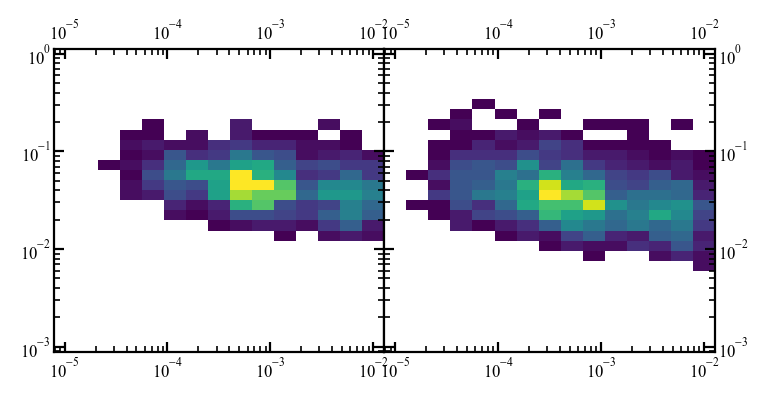

In [45]:
fig = plt.figure(figsize=utils.cm2inch(10, 5), dpi=200)

gs = plt.GridSpec(1, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = np.array([fig.add_subplot(gs[i]) for i in range(2)])

for i, hist_2d in enumerate((meas_hist_2d_pull_1, meas_hist_2d_pull_2)):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d, cmap=my_cmap_blues, vmin=0)
        
        ax[i].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i].xaxis.set_minor_formatter(ticker.NullFormatter())
        
        ax[i].tick_params(which='both',
                          left=True, right=True, top=True, bottom=True,
                          labelleft=(i==0), labelright=(i==1), labeltop=True, labelbottom=True)

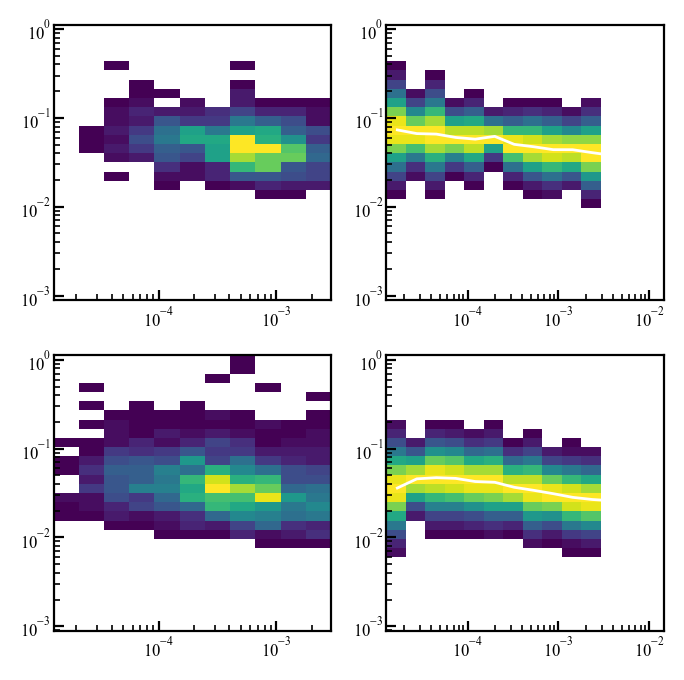

In [51]:
fig, ax = plt.subplots(2, 2, figsize=utils.cm2inch(10, 10), dpi=200)

ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')

ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')

ax[0, 0].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], meas_hist_2d_pull_1[:, 1:12], cmap=my_cmap_blues, vmin=-1)
ax[0, 1].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], hist_2d_gauss_norm_meas_pull_1[:, 1:12], cmap=my_cmap_blues)
ax[0, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_1, lw=1, c='w')

ax[1, 0].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], meas_hist_2d_pull_2[:, 1:12], cmap=my_cmap_blues, vmin=-1)
ax[1, 1].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], hist_2d_gauss_norm_meas_pull_2[:, 1:12], cmap=my_cmap_blues)
ax[1, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_2, lw=1, c='w')

### Push

In [43]:
x_mesh_meas, y_mesh_meas, meas_hist_2d_push_1 = calc_hist_2d_new(x=meas_data_push['G_meas1 [G0]'],
                                                                 y=meas_data_push['dG/G_meas1'],
                                                                 xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                                 ybins=calc_bins(np.logspace(-3, 0, 30)))

x_mesh_meas, y_mesh_meas, meas_hist_2d_push_2 = calc_hist_2d_new(x=meas_data_push['G_meas2 [G0]'],
                                                                 y=meas_data_push['dG/G_meas2'],
                                                                 xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                                 ybins=calc_bins(np.logspace(-3, 0, 30)))

In [44]:
# Gaussian fit to normalize 2D histograms
ymiddle_meas_push_1, gaussian_fit_mean_meas_push_1, gaussian_fit_mean_err_meas_push_1, hist_2d_gauss_meas_push_1, hist_2d_gauss_norm_meas_push_1 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_push_1)

ymiddle_meas_push_2, gaussian_fit_mean_meas_push_2, gaussian_fit_mean_err_meas_push_2, hist_2d_gauss_meas_push_2, hist_2d_gauss_norm_meas_push_2 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_push_2)

D:\mcbj_stmbj\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


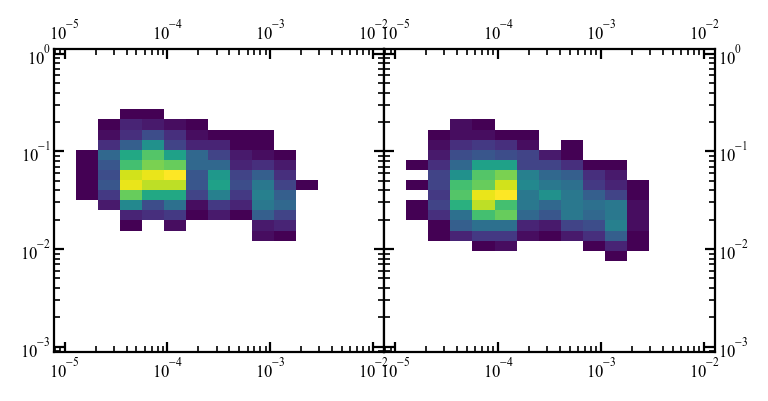

In [46]:
fig = plt.figure(figsize=utils.cm2inch(10, 5), dpi=200)

gs = plt.GridSpec(1, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = np.array([fig.add_subplot(gs[i]) for i in range(2)])

for i, hist_2d in enumerate((meas_hist_2d_push_1, meas_hist_2d_push_2)):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d, cmap=my_cmap_blues, vmin=0)
        
        ax[i].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i].xaxis.set_minor_formatter(ticker.NullFormatter())
        
        ax[i].tick_params(which='both',
                          left=True, right=True, top=True, bottom=True,
                          labelleft=(i==0), labelright=(i==1), labeltop=True, labelbottom=True)

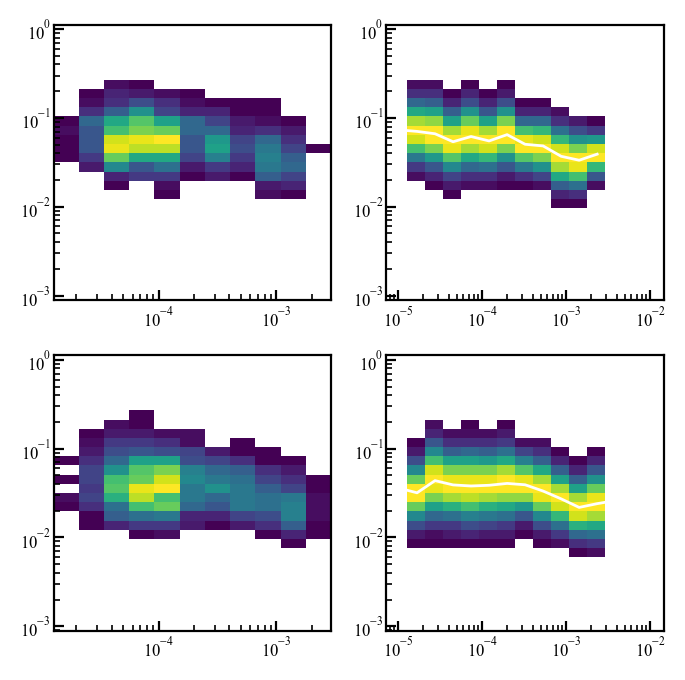

In [52]:
fig, ax = plt.subplots(2, 2, figsize=utils.cm2inch(10, 10), dpi=200)

ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')

ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')

ax[0, 0].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], meas_hist_2d_push_1[:, 1:12], cmap=my_cmap_blues, vmin=-1)
ax[0, 1].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], hist_2d_gauss_norm_meas_push_1[:, 1:12], cmap=my_cmap_blues)
ax[0, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_1, lw=1, c='w')

ax[1, 0].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], meas_hist_2d_push_2[:, 1:12], cmap=my_cmap_blues, vmin=-1)
ax[1, 1].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], hist_2d_gauss_norm_meas_push_2[:, 1:12], cmap=my_cmap_blues)
ax[1, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_2, lw=1, c='w')

## Gaussian fit to simulated histograms and calculate the square difference to measurment data

### Pull

In [107]:
# which_z = 20
# which_phi = 2

sq_diff_all_pull_1 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
sq_diff_all_pull_2 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))

for which_z in tqdm(range(dFluct.shape[0])):
    for which_phi in range(PhiFluct.shape[0]):
        ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_pull[which_z, which_phi])
        
        # compare with plateau 1
        not_any_nan_1 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:11]), np.isnan(gaussian_fit_mean_meas_pull_1[1:11])))
        sq_diff_1 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_pull_1[1:11][not_any_nan_1], y2=10**gaussian_fit_mean[1:11][not_any_nan_1], log_scale=True)
        
        sq_diff_all_pull_1[which_z, which_phi] = sq_diff_1
        
        # compare with plateau 2
        not_any_nan_2 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:11]), np.isnan(gaussian_fit_mean_meas_pull_2[1:11])))
        sq_diff_2 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_pull_2[1:11][not_any_nan_2], y2=10**gaussian_fit_mean[1:11][not_any_nan_2], log_scale=True)
        
        sq_diff_all_pull_2[which_z, which_phi] = sq_diff_2

  0%|          | 0/151 [00:00<?, ?it/s]

D:\mcbj_stmbj\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Admin\AppData\Local\Temp\ipykernel_13296\1110183324.py:32: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13296\1110183324.py:44: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


### Push

In [56]:
# which_z = 20
# which_phi = 2

sq_diff_all_push_1 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
sq_diff_all_push_2 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))

for which_z in tqdm(range(dFluct.shape[0])):
    for which_phi in range(PhiFluct.shape[0]):
        ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_push[which_z, which_phi])
        
        # compare with plateau 1
        not_any_nan_1 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:11]), np.isnan(gaussian_fit_mean_meas_push_1[1:11])))
        sq_diff_1 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_push_1[1:11][not_any_nan_1], y2=10**gaussian_fit_mean[1:11][not_any_nan_1], log_scale=True)
        
        sq_diff_all_push_1[which_z, which_phi] = sq_diff_1
        
        # compare with plateau 2
        not_any_nan_2 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:11]), np.isnan(gaussian_fit_mean_meas_push_2[1:11])))
        sq_diff_2 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_push_2[1:11][not_any_nan_2], y2=10**gaussian_fit_mean[1:11][not_any_nan_2], log_scale=True)
        
        sq_diff_all_push_2[which_z, which_phi] = sq_diff_2

  0%|          | 0/151 [00:00<?, ?it/s]

C:\Users\Admin\AppData\Local\Temp\ipykernel_13296\1110183324.py:44: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13296\1110183324.py:32: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


## Plot square difference

### Pull

(0.0, 0.06)

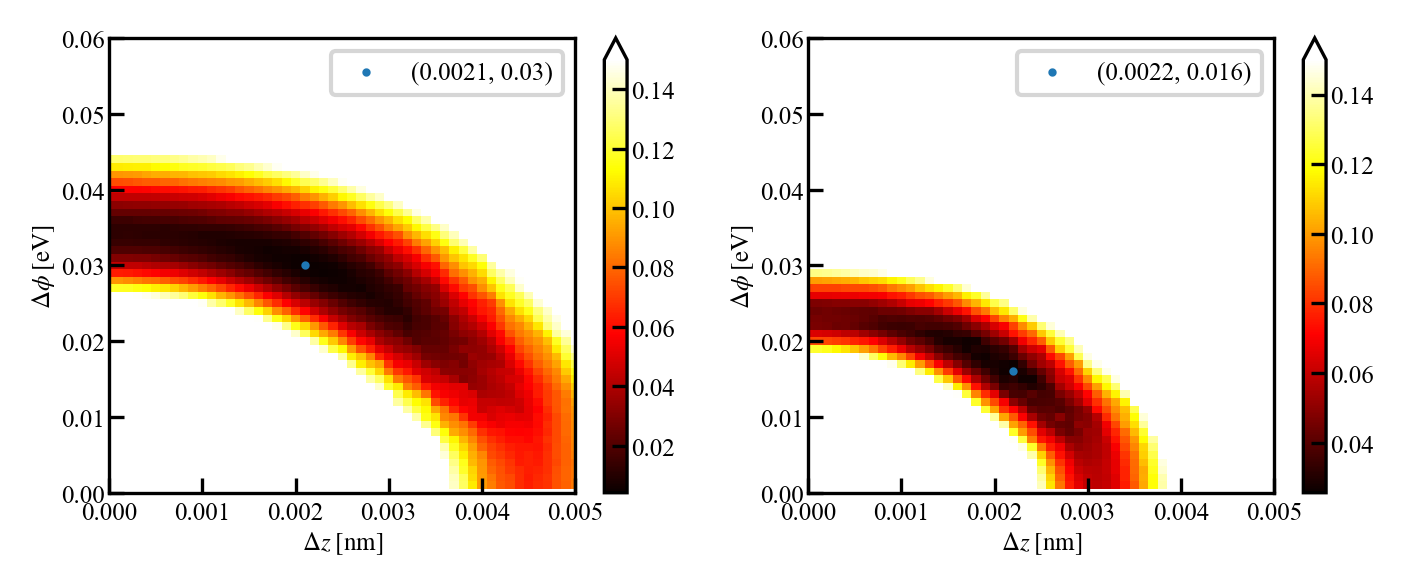

In [108]:
ax1, ax2 = plot_sq_diff_1(dFluct=dFluct, PhiFluct=PhiFluct,
               sq_diff_all_1 = sq_diff_all_pull_1, sq_diff_all_2=sq_diff_all_pull_2,
               plot_min=True, vmax=0.15)
ax1.set_xlim(0, 0.005)
ax1.set_ylim(0, 0.06)
ax2.set_xlim(0, 0.005)
ax2.set_ylim(0, 0.06)

### Push

(0.0, 0.06)

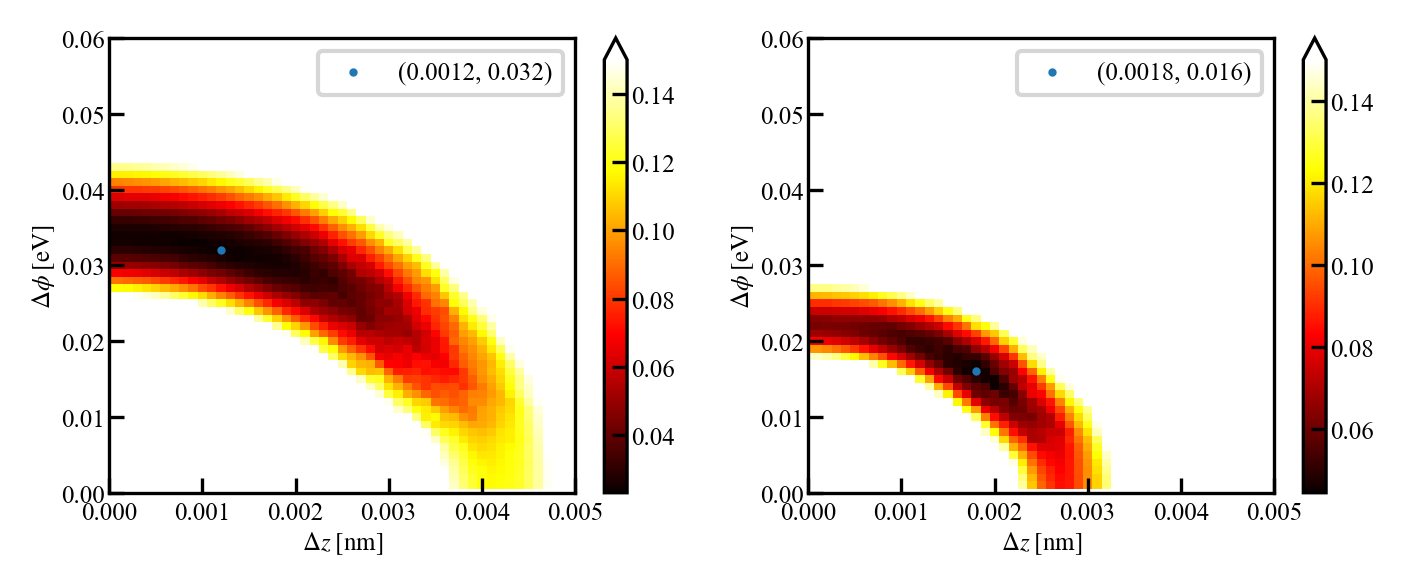

In [65]:
ax1, ax2 = plot_sq_diff_1(dFluct=dFluct, PhiFluct=PhiFluct,
               sq_diff_all_1 = sq_diff_all_push_1, sq_diff_all_2=sq_diff_all_push_2,
               plot_min=True, vmax=0.15)
ax1.set_xlim(0, 0.005)
ax1.set_ylim(0, 0.06)
ax2.set_xlim(0, 0.005)
ax2.set_ylim(0, 0.06)

In [67]:
print(sq_diff_all_push_1.flatten().min())
print(sq_diff_all_push_2.flatten().min())

0.02322566066725108
0.04452936600670282


In [69]:
sim_data_push['Phi - Barrier [eV]'].max()

1.99

4


Text(0.5, 0, 'Phi - Barrier [eV]')

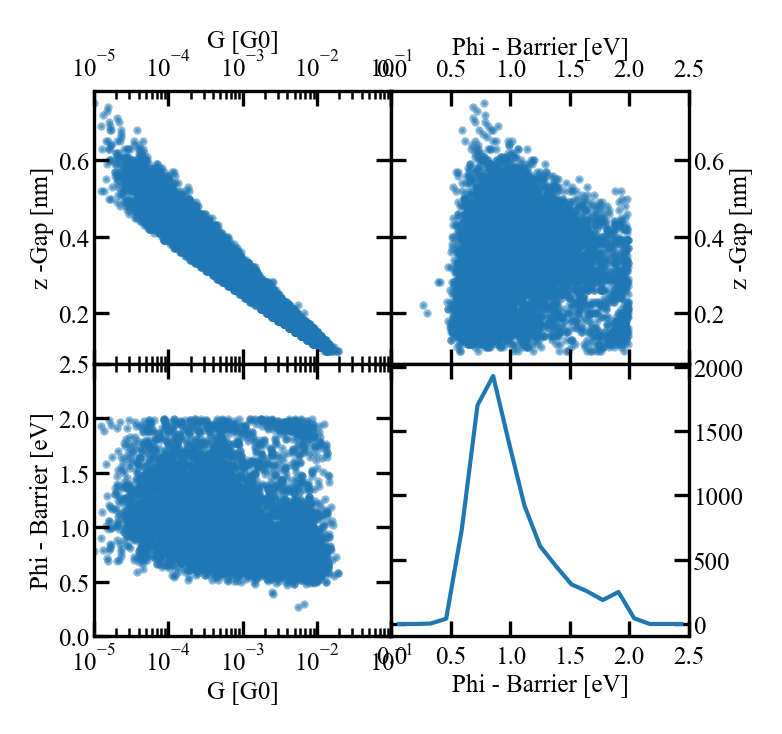

In [109]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

ax[0].scatter(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)
ax[0].set_xlabel('G [G0]')
ax[0].set_xlim(1e-5, 1e-1)
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[2].scatter(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'], s=1, alpha=0.5)
ax[2].set_xlabel('G [G0]')
ax[2].set_xlim(1e-5, 1e-1)
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[1].scatter(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)
ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')
phi_bins, phi_hist1d = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                 xbins_num=20, log_scale=False, bin_mode='total')

ax[3].plot(phi_bins, phi_hist1d, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

4


Text(0.5, 0, 'Phi - Barrier [eV]')

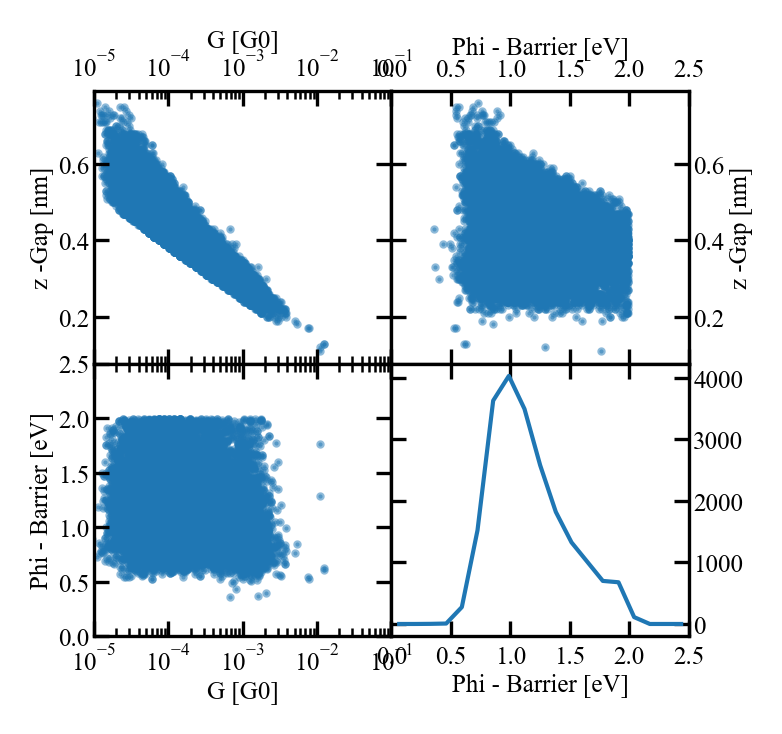

In [68]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

ax[0].scatter(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)
ax[0].set_xlabel('G [G0]')
ax[0].set_xlim(1e-5, 1e-1)
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[2].scatter(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'], s=1, alpha=0.5)
ax[2].set_xlabel('G [G0]')
ax[2].set_xlim(1e-5, 1e-1)
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[1].scatter(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)
ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')
phi_bins, phi_hist1d = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                 xbins_num=20, log_scale=False, bin_mode='total')

ax[3].plot(phi_bins, phi_hist1d, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

4


Text(0.5, 0, '$\\phi$ [eV]')

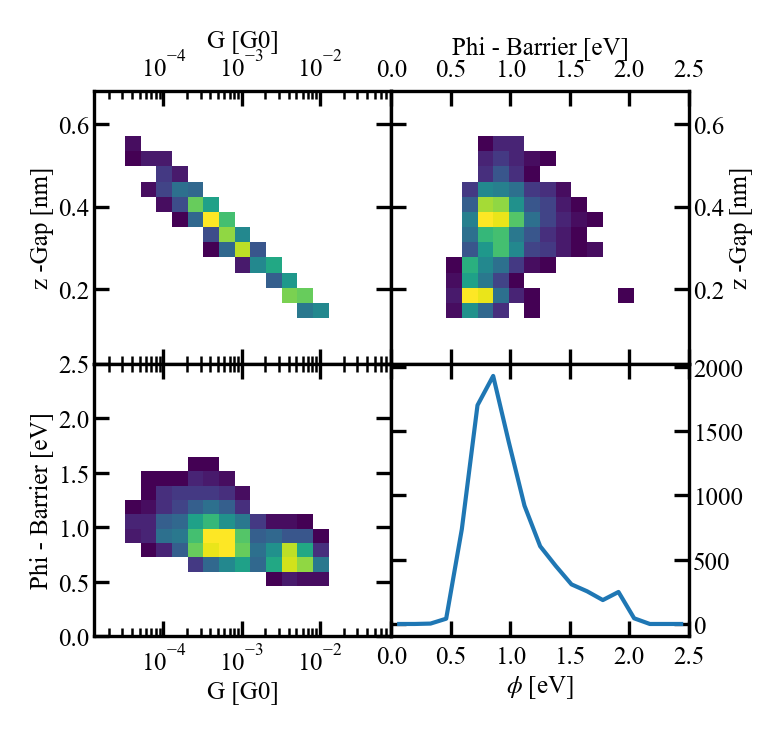

In [126]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

# ax[0].scatter(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)

bins_G, _ = utils.calc_hist_1d_single(data=sim_data_pull['G [G0]'], xrange=(1e-5, 1e-1),
                                      xbins_num=20, log_scale=True, bin_mode='total')
bins_z, _ = utils.calc_hist_1d_single(data=sim_data_pull['z -Gap [nm]'], xrange=(0, 0.7),
                                      xbins_num=20, log_scale=False, bin_mode='total')
bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                  xbins_num=20, log_scale=False, bin_mode='total')

h0, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'],
                                    bins=[bins_G, bins_z])
x_mesh0, y_mesh0 = np.meshgrid(xedges, yedges)
im0 = ax[0].pcolormesh(x_mesh0, y_mesh0, h0.T, cmap=my_cmap, vmin=h0.flatten().max()*0.1)

ax[0].set_xlabel('G [G0]')
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[2].scatter(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'], s=1, alpha=0.5)

h2, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
x_mesh2, y_mesh2 = np.meshgrid(xedges, yedges)
im2 = ax[2].pcolormesh(x_mesh2, y_mesh2, h2.T, cmap=my_cmap, vmin=h2.flatten().max()*0.1)

ax[2].set_xlabel('G [G0]')
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[1].scatter(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)

h1, xedges, yedges = np.histogram2d(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'],
                                    bins=[bins_Phi, bins_z])
x_mesh1, y_mesh1 = np.meshgrid(xedges, yedges)
im1 = ax[1].pcolormesh(x_mesh1, y_mesh1, h1.T, cmap=my_cmap, vmin=h1.flatten().max()*0.1)

ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')

# axin1 = ax[2].inset_axes([0.8, 0.1, 0.15, 0.5])
# fig.colorbar(im2, ax=ax[2], extend='max')

ax[3].plot(bins_Phi, hist_1d_Phi, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel(r'$\phi$ [eV]')

4


Text(0.5, 0, 'Phi - Barrier [eV]')

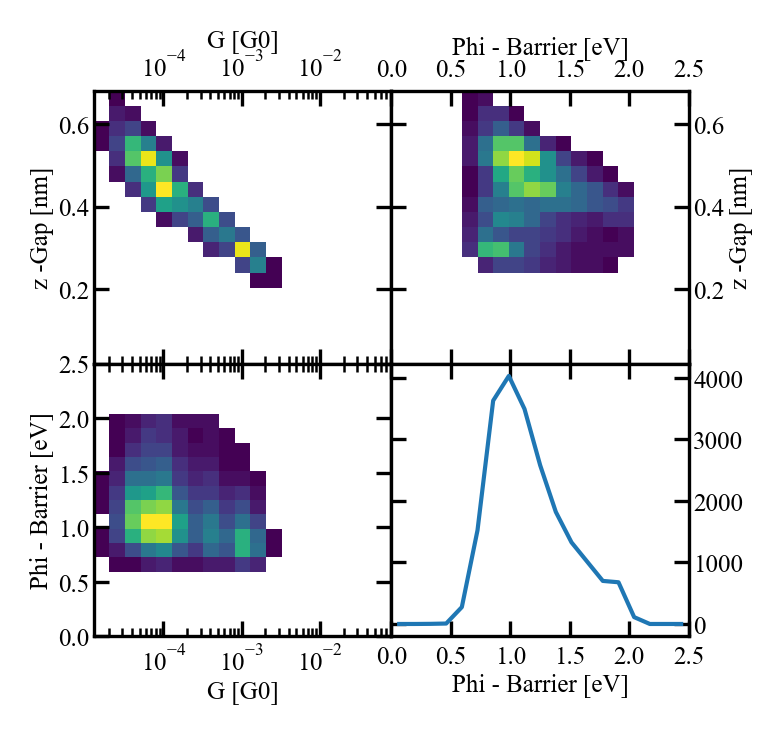

In [72]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

# ax[0].scatter(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)

bins_G, _ = utils.calc_hist_1d_single(data=sim_data_push['G [G0]'], xrange=(1e-5, 1e-1),
                                      xbins_num=20, log_scale=True, bin_mode='total')
bins_z, _ = utils.calc_hist_1d_single(data=sim_data_push['z -Gap [nm]'], xrange=(0, 0.7),
                                      xbins_num=20, log_scale=False, bin_mode='total')
bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                  xbins_num=20, log_scale=False, bin_mode='total')

h0, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'],
                                    bins=[bins_G, bins_z])
x_mesh0, y_mesh0 = np.meshgrid(xedges, yedges)
im0 = ax[0].pcolormesh(x_mesh0, y_mesh0, h0.T, cmap=my_cmap, vmin=-1)

ax[0].set_xlabel('G [G0]')
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[2].scatter(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'], s=1, alpha=0.5)

h2, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
x_mesh2, y_mesh2 = np.meshgrid(xedges, yedges)
im2 = ax[2].pcolormesh(x_mesh2, y_mesh2, h2.T, cmap=my_cmap, vmin=-1)

ax[2].set_xlabel('G [G0]')
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[1].scatter(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)

h1, xedges, yedges = np.histogram2d(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'],
                                    bins=[bins_Phi, bins_z])
x_mesh1, y_mesh1 = np.meshgrid(xedges, yedges)
im1 = ax[1].pcolormesh(x_mesh1, y_mesh1, h1.T, cmap=my_cmap, vmin=-1)

ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')

ax[3].plot(bins_Phi, hist_1d_Phi, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

In [73]:
sim_data_pull.head()

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0]
0,19522,'1_IV_trace_19522_pull_pl',13069957.0,0.32,0.77,1.563003e+17,1.099730e+26,0.002974,0.085796,0.001155,0.143681,1,0.000105
639,19522,'2_IV_trace_19522_pull_pl',12976073.0,0.33,0.68,1.483611e+17,1.122828e+26,0.002974,0.085796,0.001155,0.143681,1,0.000080
1278,19522,'3_IV_trace_19522_pull_pl',17213803.0,0.27,1.76,2.784074e+17,8.233249e+25,0.002974,0.085796,0.001155,0.143681,1,0.000088
1917,19522,'4_IV_trace_19522_pull_pl',20498335.0,0.36,0.76,2.371568e+17,1.994190e+26,0.002974,0.085796,0.001155,0.143681,1,0.001912
1,19811,'1_IV_trace_19811_pull_pl',3730296.1,0.21,0.92,5.156197e+16,1.692375e+25,0.005064,0.107289,0.002731,0.043851,1,0.000075


Text(0, 0.5, 'Simulated G [G0]')

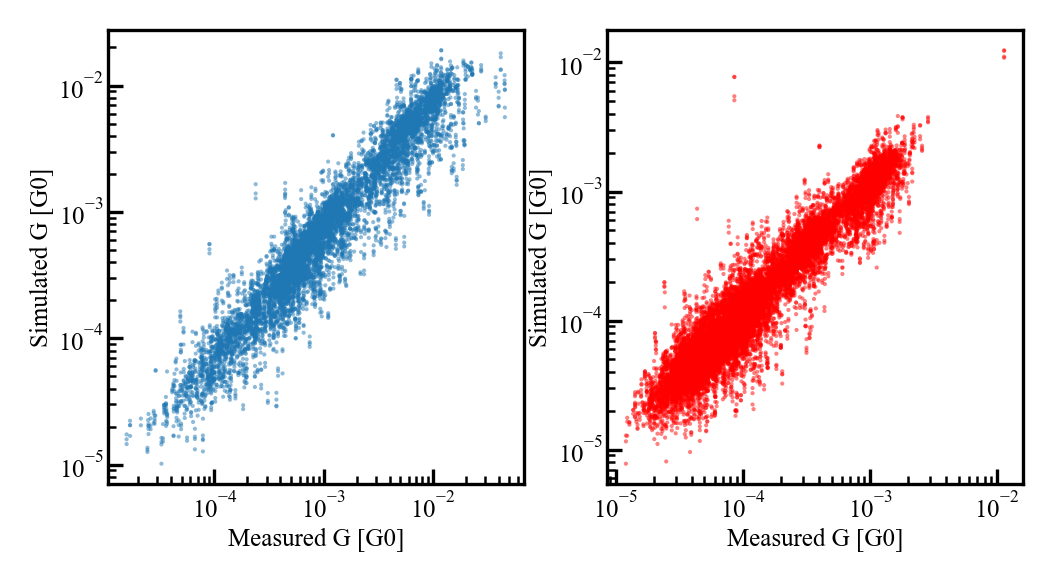

In [122]:
fig, ax = plt.subplots(1, 2, figsize=utils.cm2inch(10, 5), dpi=300)
ax[0].scatter(sim_data_pull['G_meas1 [G0]'], sim_data_pull['G [G0]'], s=1, alpha=0.5, edgecolor='None')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Measured G [G0]')
ax[0].set_ylabel('Simulated G [G0]')

ax[1].scatter(sim_data_push['G_meas1 [G0]'], sim_data_push['G [G0]'], s=1, alpha=0.5, edgecolor='None', c='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Measured G [G0]')
ax[1].set_ylabel('Simulated G [G0]')

## Plot
### ax1: gap 2D histogram + inset: sim vs measured conductance 2D histogram
### ax2: barrier 2D histogram + inset distribution of the barrier in a 2-3 bin wide slice

In [137]:
def calc_bins(middle: np.ndarray, log_scale=True):
    """
    Parameters
    ----------
    middle : np.ndarray
        location of the center of each bin for the histogram
    log_scale : bool
        if True, calculate bins on logarithmic scale
        

    Returns
    -------
    np.ndarray
        calculated bin edge locations

    Examples
    --------
    >>> calc_bins(middle=np.logspace(-5, -3, 2), log_scale=True)
    array([1.e-06, 1.e-04, 1.e-02])
    
    >>> calc_bins(middle=np.linspace(0, 2, 2), log_scale=False)
    array([-1.,  1.,  3.])
    
    >>> calc_bins(middle=np.linspace(0, 2, 5), log_scale=False)
    array([-0.25,  0.25,  0.75,  1.25,  1.75,  2.25])
    """
    
    if log_scale:
        bin_width = np.mean(np.diff(np.log10(middle)))
        return np.append(10**(np.log10(middle)-bin_width/2), 10**(np.log10(middle[-1])+bin_width/2))
    else:
        bin_width = np.mean(np.diff(middle))
        return np.append(middle-bin_width/2, middle[-1]+bin_width/2)

### push

2


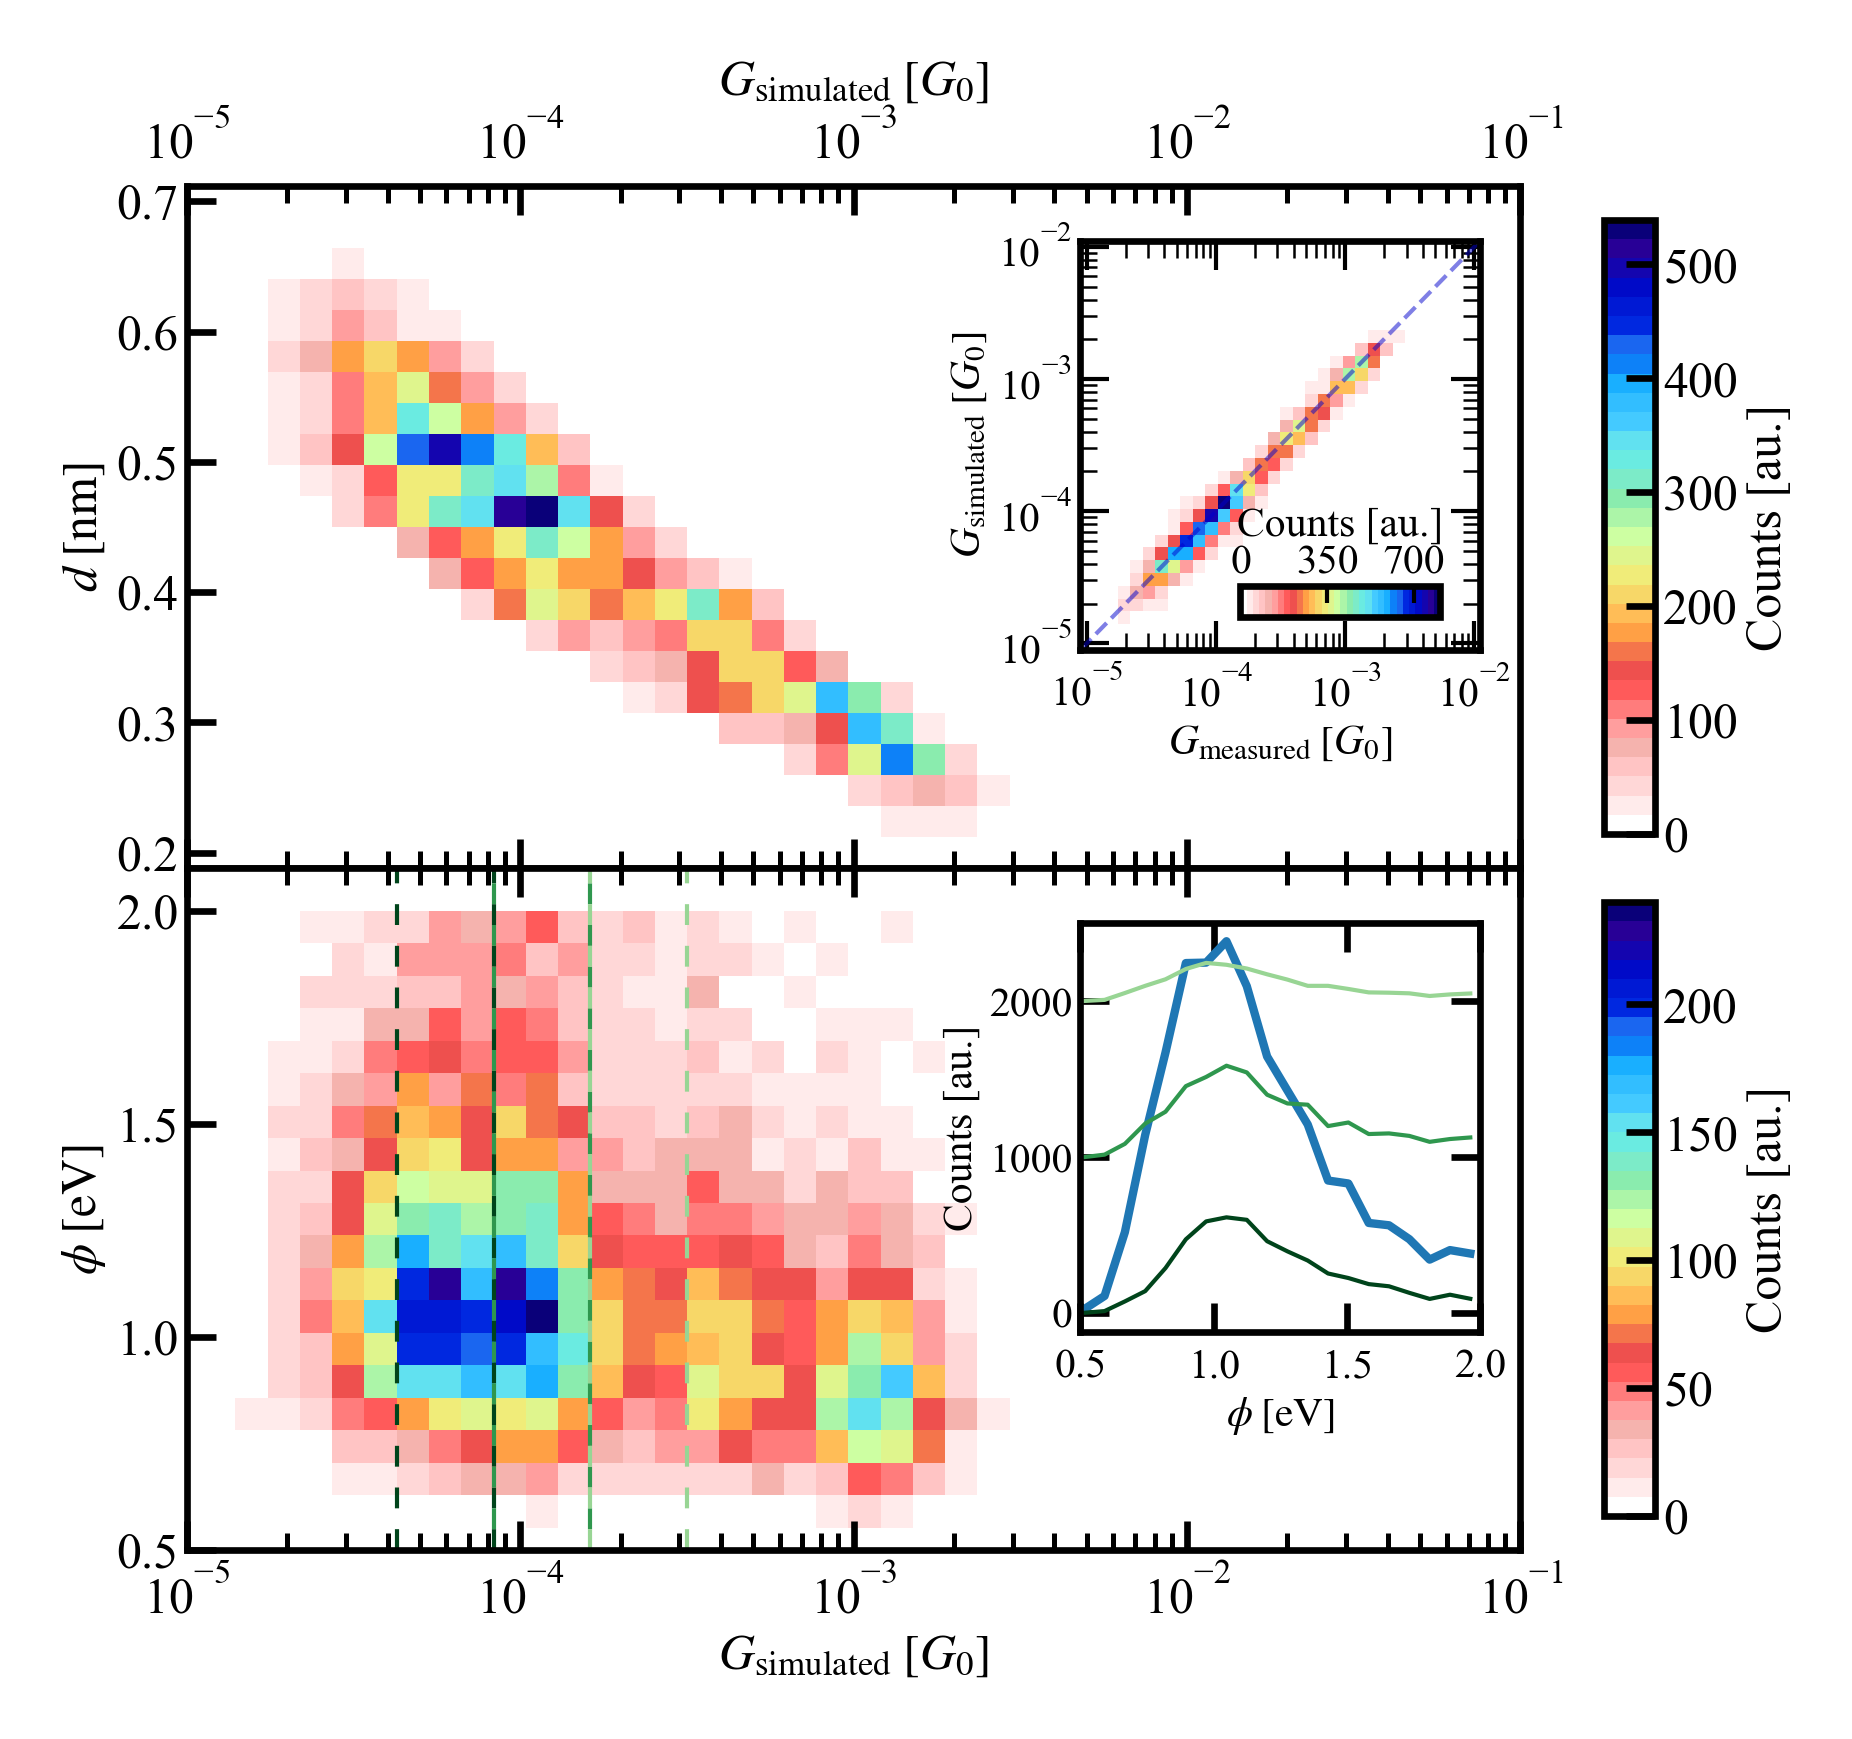

In [375]:
# bins_G, _ = utils.calc_hist_1d_single(data=sim_data_push['G [G0]'], xrange=(1e-5, 1e-1),
#                                       xbins_num=20, log_scale=True, bin_mode='total')
# bins_z, _ = utils.calc_hist_1d_single(data=sim_data_push['z -Gap [nm]'], xrange=(0, 0.7),
#                                       xbins_num=20, log_scale=False, bin_mode='total')
# bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
#                                                   xbins_num=20, log_scale=False, bin_mode='total')

figsize = utils.cm2inch((8.4, 7.5))
dpi = 600

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 1, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i]) for i in range(2)]
axin = [a.inset_axes([0.67, 0.32, 0.3, 0.6]) for a in ax]

axc_cond = axin[0].inset_axes([0.4, 0.08, 0.5, 0.075])

print(len(ax))

axin[0].tick_params(axis='both', labelsize=5)
axin[1].tick_params(axis='both', labelsize=5)

ax[0].set_xscale('log')
axin[0].set_xscale('log')
axin[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(1e-5, 1e-1)
ax[1].set_xlim(1e-5, 1e-1)
ax[0].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)

middle_G = np.logspace(-5, -2, 32)
hist_1d_G, bins_G  = np.histogram(sim_data_push['G [G0]'], bins=calc_bins(middle=middle_G, log_scale=True))

middle_z = np.linspace(0.2, 0.7, 22)

hist_1d_z, bins_z  = np.histogram(sim_data_push['z -Gap [nm]'], bins=calc_bins(middle=middle_z, log_scale=False))



hist_1d_Phi, bins_Phi  = np.histogram(sim_data_push['Phi - Barrier [eV]'], bins = np.linspace(0.4, 2., 22))
bar_width = np.diff(bins_Phi)
middle_Phi = bins_Phi[:-1] + bar_width / 2


gap_2D, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'],
                                        bins=[bins_G, bins_z])
gap_2D = gap_2D.T

x_mesh_gap, y_mesh_gap = np.meshgrid(xedges, yedges)
im_gap = ax[0].pcolormesh(x_mesh_gap, y_mesh_gap, gap_2D, cmap=utils.cmap_geo32, vmin=0)

barrier_2d, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
barrier_2d = barrier_2d.T

x_mesh_barrier, y_mesh_barrier = np.meshgrid(xedges, yedges)
im_barrier = ax[1].pcolormesh(x_mesh_barrier, y_mesh_barrier, barrier_2d, cmap=utils.cmap_geo32, vmin=0)

ax[1].set_ylim(0.5, 2.1)

cond_2D, xedges, yedges = np.histogram2d(sim_data_push['G_meas2 [G0]'], sim_data_push['G [G0]'],
                                         bins=[bins_G, bins_G])
x_mesh_cond, y_mesh_cond = np.meshgrid(xedges, yedges)
cond_2D = cond_2D.T

im_cond = axin[0].pcolormesh(x_mesh_cond, y_mesh_cond, cond_2D, cmap=utils.cmap_geo32, vmin=0)

axin[1].plot(middle_Phi, hist_1d_Phi, lw=1)
axin[1].set_xlim(0.5, 2)

ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', labelpad=2)
ax[0].set_ylabel(r'$d\;[\mathrm{nm}]$')

ax[1].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$')
ax[1].set_ylabel(r'$\phi\;[\mathrm{eV}]$')

axin[0].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', fontsize=5)
axin[0].set_ylabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', fontsize=5)

axin[1].set_xlabel(r'$\phi\;[\mathrm{eV}]$', fontsize=5)
axin[1].set_ylabel(r'Counts [au.]', fontsize=5)

axin[0].plot(bins_G, bins_G, ls='--', lw=0.5, c='mediumblue', alpha=0.5)
axin[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].tick_params(axis='both', which='major', width=0.5)
axin[0].tick_params(axis='both', which='minor', width=0.3)

my_oranges = colormaps['Greens'](np.linspace(0.4, 1, 3))[::-1]

ax[1].axvline(bins_G[7], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[10], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[10], ls=(5, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[13], ls=(5, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[2])
ax[1].axvline(bins_G[16], ls=(0, (5, 5)), lw=0.5, c=my_oranges[2])

axin[1].plot(middle_Phi, barrier_2d[:, 7:10].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 10:13].sum(axis=1)+1000, lw=0.5, c=my_oranges[1])
axin[1].plot(middle_Phi, barrier_2d[:, 13:16].sum(axis=1)+2000, lw=0.5, c=my_oranges[2])

fig.colorbar(im_gap, ax=ax[0], shrink=0.9, aspect=12, label='Counts [au.]')
fig.colorbar(im_barrier, ax=ax[1], shrink=0.9, aspect=12, label='Counts [au.]')
fig.colorbar(im_cond, cax=axc_cond, shrink=0.9, aspect=12, orientation='horizontal', ticks=[0, 350, 700])
axc_cond.tick_params(axis='x', labelsize=5, width=0.5, size=2, top=True, bottom=False, labeltop=True, labelbottom=False, pad=0.5)
axc_cond.xaxis.set_label_position('top')
axc_cond.set_xlabel('Counts [au.]', fontsize=5)
plt.savefig(home_folder_1.joinpath(f'results/article/gap_barrier_conductance_distribution_push_2.png'), bbox_inches='tight')

2


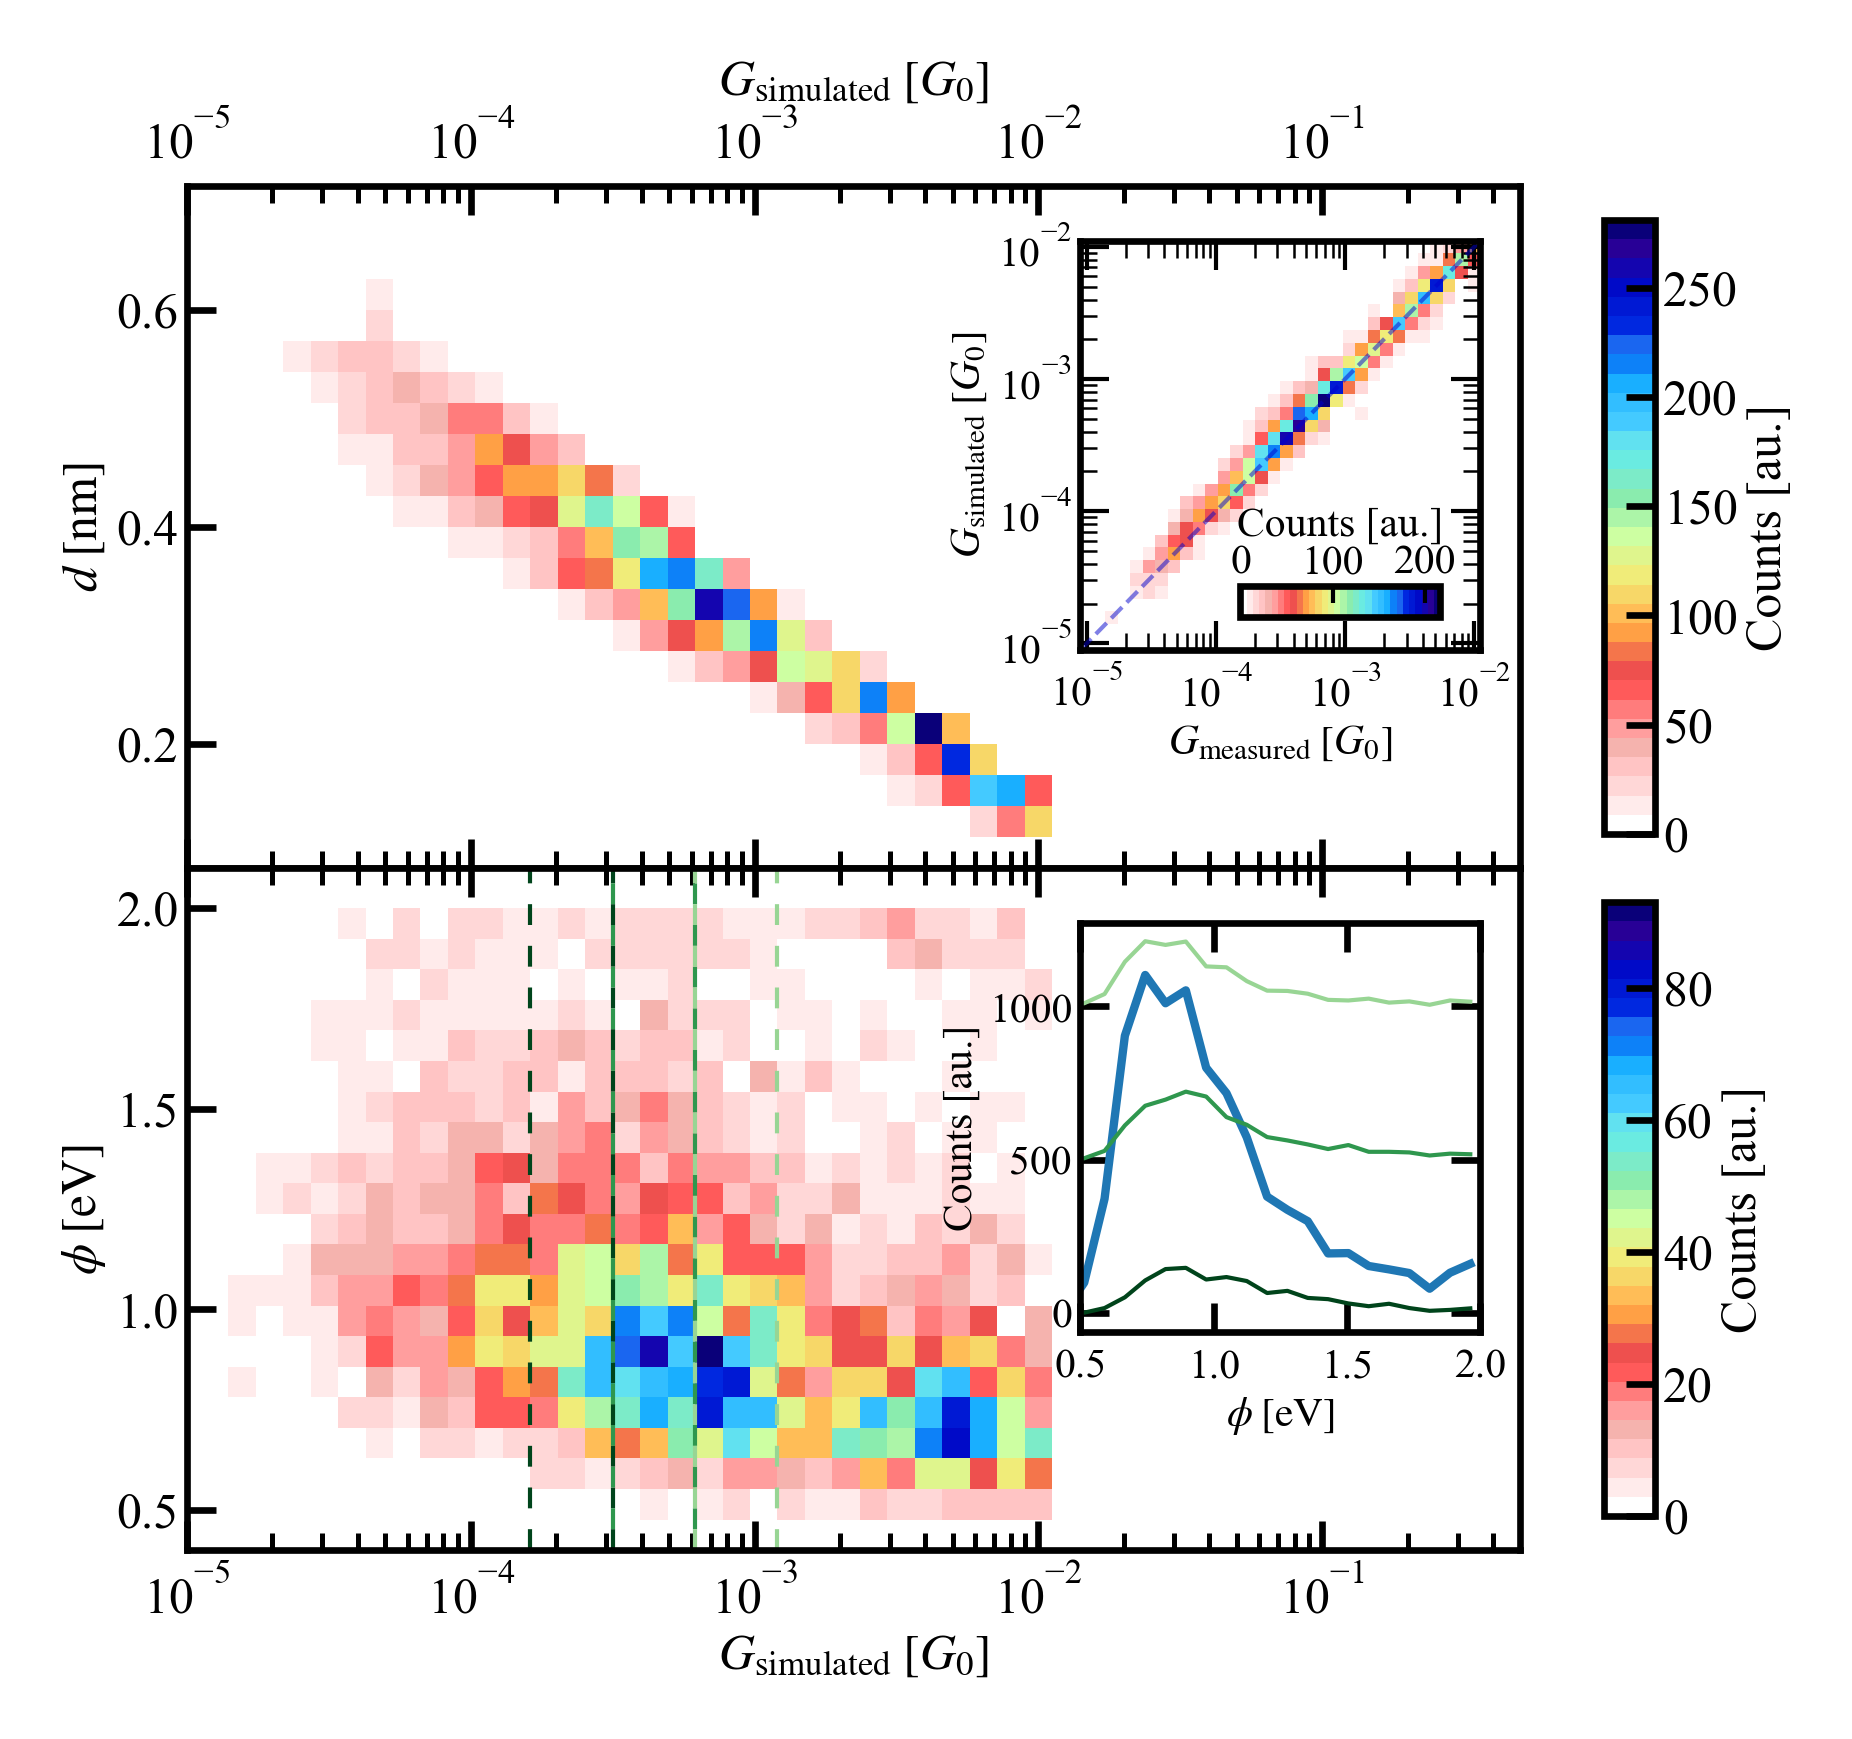

In [379]:
# bins_G, _ = utils.calc_hist_1d_single(data=sim_data_pull['G [G0]'], xrange=(1e-5, 1e-1),
#                                       xbins_num=20, log_scale=True, bin_mode='total')
# bins_z, _ = utils.calc_hist_1d_single(data=sim_data_pull['z -Gap [nm]'], xrange=(0, 0.7),
#                                       xbins_num=20, log_scale=False, bin_mode='total')
# bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
#                                                   xbins_num=20, log_scale=False, bin_mode='total')

figsize = utils.cm2inch((8.4, 7.5))
dpi = 600

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 1, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i]) for i in range(2)]
axin = [a.inset_axes([0.67, 0.32, 0.3, 0.6]) for a in ax]

axc_cond = axin[0].inset_axes([0.4, 0.08, 0.5, 0.075])

print(len(ax))

axin[0].tick_params(axis='both', labelsize=5)
axin[1].tick_params(axis='both', labelsize=5)

ax[0].set_xscale('log')
axin[0].set_xscale('log')
axin[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(1e-5, 5e-1)
ax[1].set_xlim(1e-5, 5e-1)
ax[0].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)

middle_G = np.logspace(-5, -2, 32)
hist_1d_G, bins_G  = np.histogram(sim_data_pull['G [G0]'], bins=calc_bins(middle=middle_G, log_scale=True))

middle_z = np.linspace(0.1, 0.7, 22)

hist_1d_z, bins_z  = np.histogram(sim_data_pull['z -Gap [nm]'], bins=calc_bins(middle=middle_z, log_scale=False))



hist_1d_Phi, bins_Phi  = np.histogram(sim_data_pull['Phi - Barrier [eV]'], bins = np.linspace(0.4, 2., 22))
bar_width = np.diff(bins_Phi)
middle_Phi = bins_Phi[:-1] + bar_width / 2


gap_2D, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'],
                                        bins=[bins_G, bins_z])
gap_2D = gap_2D.T

x_mesh_gap, y_mesh_gap = np.meshgrid(xedges, yedges)
im_gap = ax[0].pcolormesh(x_mesh_gap, y_mesh_gap, gap_2D, cmap=utils.cmap_geo32, vmin=0)

barrier_2d, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
barrier_2d = barrier_2d.T

x_mesh_barrier, y_mesh_barrier = np.meshgrid(xedges, yedges)
im_barrier = ax[1].pcolormesh(x_mesh_barrier, y_mesh_barrier, barrier_2d, cmap=utils.cmap_geo32, vmin=0)

ax[1].set_ylim(0.4, 2.1)

cond_2D, xedges, yedges = np.histogram2d(sim_data_pull['G_meas2 [G0]'], sim_data_pull['G [G0]'],
                                         bins=[bins_G, bins_G])
x_mesh_cond, y_mesh_cond = np.meshgrid(xedges, yedges)
cond_2D = cond_2D.T

im_cond = axin[0].pcolormesh(x_mesh_cond, y_mesh_cond, cond_2D, cmap=utils.cmap_geo32, vmin=0)

axin[1].plot(middle_Phi, hist_1d_Phi, lw=1)
axin[1].set_xlim(0.5, 2)

ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', labelpad=2)
ax[0].set_ylabel(r'$d\;[\mathrm{nm}]$')

ax[1].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$')
ax[1].set_ylabel(r'$\phi\;[\mathrm{eV}]$')

axin[0].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', fontsize=5)
axin[0].set_ylabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', fontsize=5)

axin[1].set_xlabel(r'$\phi\;[\mathrm{eV}]$', fontsize=5)
axin[1].set_ylabel(r'Counts [au.]', fontsize=5)

axin[0].plot(bins_G, bins_G, ls='--', lw=0.5, c='mediumblue', alpha=0.5)
axin[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].tick_params(axis='both', which='major', width=0.5)
axin[0].tick_params(axis='both', which='minor', width=0.3)

my_oranges = colormaps['Greens'](np.linspace(0.4, 1, 3))[::-1]

ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[16], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[16], ls=(5, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[19], ls=(5, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[19], ls=(0, (5, 5)), lw=0.5, c=my_oranges[2])
ax[1].axvline(bins_G[22], ls=(0, (5, 5)), lw=0.5, c=my_oranges[2])

axin[1].plot(middle_Phi, barrier_2d[:, 13:16].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 16:19].sum(axis=1)+500, lw=0.5, c=my_oranges[1])
axin[1].plot(middle_Phi, barrier_2d[:, 19:22].sum(axis=1)+1000, lw=0.5, c=my_oranges[2])

fig.colorbar(im_gap, ax=ax[0], shrink=0.9, aspect=12, label='Counts [au.]')
fig.colorbar(im_barrier, ax=ax[1], shrink=0.9, aspect=12, label='Counts [au.]')
fig.colorbar(im_cond, cax=axc_cond, shrink=0.9, aspect=12, orientation='horizontal', ticks=[0, 100, 200]) # 90, 180
axc_cond.tick_params(axis='x', labelsize=5, width=0.5, size=2, top=True, bottom=False, labeltop=True, labelbottom=False, pad=0.5)
axc_cond.xaxis.set_label_position('top')
axc_cond.set_xlabel('Counts [au.]', fontsize=5)
plt.savefig(home_folder_1.joinpath(f'results/article/gap_barrier_conductance_distribution_pull_2.png'), bbox_inches='tight')

3


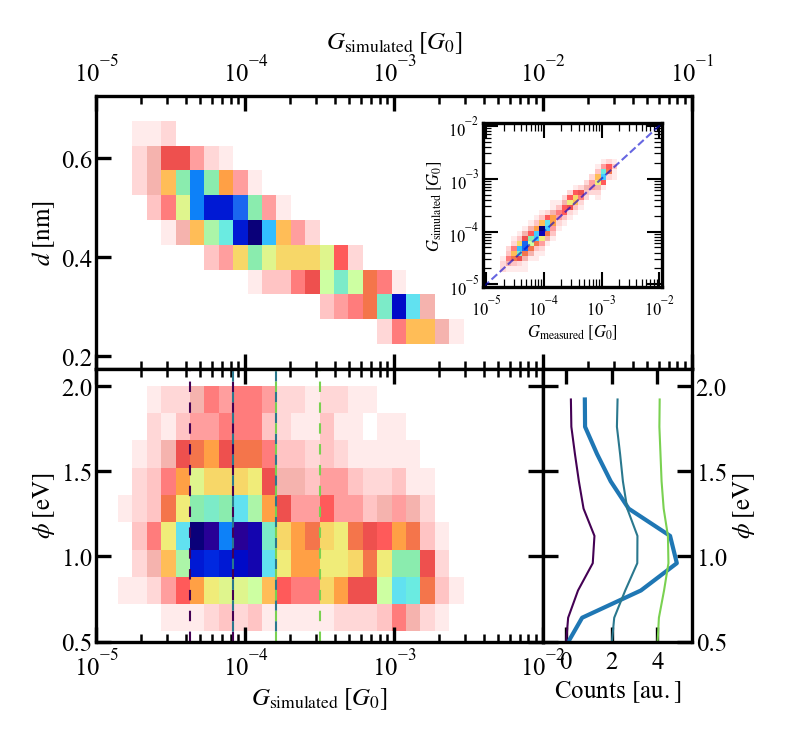

In [314]:
# bins_G, _ = utils.calc_hist_1d_single(data=sim_data_push['G [G0]'], xrange=(1e-5, 1e-1),
#                                       xbins_num=20, log_scale=True, bin_mode='total')
# bins_z, _ = utils.calc_hist_1d_single(data=sim_data_push['z -Gap [nm]'], xrange=(0, 0.7),
#                                       xbins_num=20, log_scale=False, bin_mode='total')
# bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
#                                                   xbins_num=20, log_scale=False, bin_mode='total')

figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0,
                  width_ratios=(3, 1), height_ratios=(1, 1))

ax = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]
axin = [ax[0].inset_axes([0.65, 0.3, 0.3, 0.6])]
print(len(ax))

axin[0].tick_params(axis='both', labelsize=4)

ax[0].set_xscale('log')
axin[0].set_xscale('log')
axin[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(1e-5, 1e-1)
ax[1].set_xlim(1e-5, 1e-2)
ax[0].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)
axin[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)

middle_G = np.logspace(-5, -2, 32)
hist_1d_G, bins_G  = np.histogram(sim_data_push['G [G0]'], bins=calc_bins(middle=middle_G, log_scale=True))

middle_z = np.linspace(0.2, 0.7, 11)

hist_1d_z, bins_z  = np.histogram(sim_data_push['z -Gap [nm]'], bins=calc_bins(middle=middle_z, log_scale=False))



hist_1d_Phi, bins_Phi  = np.histogram(sim_data_push['Phi - Barrier [eV]'], bins = np.linspace(0.4, 2., 11))
bar_width = np.diff(bins_Phi)
middle_Phi = bins_Phi[:-1] + bar_width / 2


gap_2D, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'],
                                        bins=[bins_G, bins_z])
gap_2D = gap_2D.T

x_mesh_gap, y_mesh_gap = np.meshgrid(xedges, yedges)
im_gap = ax[0].pcolormesh(x_mesh_gap, y_mesh_gap, gap_2D, cmap=utils.cmap_geo32, vmin=-1)

barrier_2d, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
barrier_2d = barrier_2d.T

x_mesh_barrier, y_mesh_barrier = np.meshgrid(xedges, yedges)
im_barrier = ax[1].pcolormesh(x_mesh_barrier, y_mesh_barrier, barrier_2d, cmap=utils.cmap_geo32, vmin=-1)

ax[1].set_ylim(0.5, 2.1)

cond_2D, xedges, yedges = np.histogram2d(sim_data_push['G_meas1 [G0]'], sim_data_push['G [G0]'],
                                         bins=[bins_G, bins_G])
cond_2D = cond_2D.T

x_mesh_cond, y_mesh_cond = np.meshgrid(xedges, yedges)
im_cond = axin[0].pcolormesh(x_mesh_cond, y_mesh_cond, cond_2D, cmap=utils.cmap_geo32, vmin=-1)

ax[2].plot(hist_1d_Phi, middle_Phi, lw=1)
ax[2].set_ylim(ax[1].get_ylim())


# ax[0].axvline(3e-3, ls='--', lw=0.5)

# my_oranges = colormaps['Oranges'](np.linspace(0.3, 0.9, 3))
my_oranges = colormaps['viridis'](np.linspace(0, 0.8, 3))

ax[1].axvline(bins_G[7], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[10], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[10], ls=(5, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[13], ls=(5, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[2])
ax[1].axvline(bins_G[16], ls=(0, (5, 5)), lw=0.5, c=my_oranges[2])

ax[2].plot(barrier_2d[:, 7:10].sum(axis=1), middle_Phi, lw=0.5, c=my_oranges[0])
ax[2].plot(barrier_2d[:, 10:13].sum(axis=1)+2000, middle_Phi, lw=0.5, c=my_oranges[1])
ax[2].plot(barrier_2d[:, 13:16].sum(axis=1)+4000, middle_Phi, lw=0.5, c=my_oranges[2])

ax[2].set_xlim(-1000, 5500)

ax[0].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', labelpad=2)
ax[0].set_ylabel(r'$d\;[\mathrm{nm}]$')

ax[1].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$')
ax[1].set_ylabel(r'$\phi\;[\mathrm{eV}]$')

ax[2].set_xlabel(r'Counts $[\mathrm{au.}]$')
ax[2].set_ylabel(r'$\phi\;[\mathrm{eV}]$')

axin[0].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', fontsize=4)
axin[0].set_ylabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', fontsize=4)

ax[0].xaxis.set_label_position('top')
ax[2].yaxis.set_label_position('right')
ax[2].set_xticks(np.arange(0, 5001, 2000))
ax[2].set_xticklabels(np.arange(0, 5, 2))
ax[2].tick_params(axis='x', rotation=0)

axin[0].plot(bins_G, bins_G, ls='--', lw=0.5, c='mediumblue', alpha=0.6)
axin[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].tick_params(axis='both', which='major', width=0.5)
axin[0].tick_params(axis='both', which='minor', width=0.3)

# fig.colorbar(im_gap, ax=ax[0])

# ax[1].axvline(middle_G[7], ls='--', lw=0.5, c='r')
plt.savefig(home_folder_1.joinpath(f'results/article/gap_barrier_conductance_distribution_2.png'), bbox_inches='tight')

In [371]:
print(max(gap_2D.flatten()))
print(max(barrier_2d.flatten()))
print(max(cond_2D.flatten()))

281.0
93.0
197.0


In [239]:
barrier_2d[:, 7:10].sum(axis=1)

array([   3.,  102.,  533., 1177., 1251.,  775.,  571.,  399.,  242.,
        222.])

In [242]:
bins_G.shape

(33,)

In [172]:
np.linspace(0, 0.7, 15)


array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 ])